## Cloning GIT Repo

In [1]:
!export PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:128
!git clone https://github.com/abhijeetu1912/EVA.git
!mv EVA/S5/model.py .

Cloning into 'EVA'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 241 (delta 11), reused 21 (delta 6), pack-reused 215
Receiving objects: 100% (241/241), 2.06 MiB | 20.89 MiB/s, done.
Resolving deltas: 100% (88/88), done.


# Import Libraries

In [2]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# load required libraries
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from tqdm import tqdm
from model import Net
from torchsummary import summary

## Data Transformations


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                     ])


# Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1
batch_size = 64

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else \
                  dict(shuffle=True, batch_size=batch_size//2)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Device

In [7]:
# device initialization
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


# Training and Testing Module

In [8]:
# trainer to train the model
class Trainer:
    def __init__(self, model, train_loader, criterion, optimizer, device, scheduler, l1_reg = 0):
        self.model = model
        self.train_loader = train_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.train_losses = []
        self.train_accs = []
        self.l1_reg = l1_reg

    def train(self):
        # use model in training mode
        self.model.train()
        # track number of correct classifications & data points processed
        correct = 0
        processed = 0    
        #progress bar
        pbar = tqdm(self.train_loader)
        # iterate over batches
        for batch_id, (inputs, targets) in enumerate(pbar):
            # set device
            images, targets = inputs.to(self.device), targets.to(self.device)
            # zero out or flush gradients from last batch
            self.optimizer.zero_grad()
            # predict output
            outputs = self.model(images)
            # calculate loss
            loss = self.criterion(outputs, targets)
            # add l1 penalty to loss
            if self.l1_reg > 0:
               l1_norm = sum(p.abs().sum() for p in self.model.parameters())
               loss += self.l1_reg * l1_norm
            # append batch train loss
            self.train_losses.append(loss.item())
            # backpropogate loss
            loss.backward()
            # update weights 
            self.optimizer.step()
            # predict class
            pred = outputs.argmax(dim=1, keepdim=True)
            # count correctly classified data points
            correct += pred.eq(targets.view_as(pred)).sum().item()
            # count number of data points processed till this iteration
            processed += len(inputs)
            # append train accuracy
            self.train_accs.append(100 * correct / processed)
            # show progress bar
            pbar.set_description(
                desc=f"Loss = {loss.item():3.2f} | Batch = {batch_id} | Accuracy = {self.train_accs[-1]:0.2f}"
            )


# tester to test the model
class Tester:
    def __init__(self, model, test_loader, criterion, device):
        self.model = model
        self.test_loader = test_loader
        self.criterion = criterion
        self.device = device
        self.test_losses = []
        self.test_accs = []

    def test(self):
        #use model in evaluation mode
        self.model.eval()
        # number of correctly classified data points
        correct = 0
        # batch test loss
        batch_loss = 0
        # execute without gradients
        with torch.no_grad():
            #iterate over batches
            for data, target in self.test_loader:
                # set device
                data, target = data.to(self.device), target.to(self.device)
                # predict output
                outputs = self.model(data)
                # calculate and add up loss over batches
                batch_loss += self.criterion(outputs, target).item() 
                # predict class
                pred = outputs.argmax(dim=1, keepdim=True)
                # update number of correctly classified ata points
                correct += pred.eq(target.view_as(pred)).sum().item()
            # append average test loss of epoch
            self.test_losses.append(batch_loss / len(self.test_loader.dataset))
            # append test accuracy
            self.test_accs.append(100 * correct / len(self.test_loader.dataset))
            # print epoch statistics
            print('\nTest set: Average loss: {:.5f}, Accuracy: {:.2f}\n'.format(
                  self.test_losses[-1], self.test_accs[-1]))


# evaluate final model
def evaluate(model, data_loader, criterion, device, split = 'Test'):
    #use model in evaluation mode
    model.eval()
    # number of correctly classified data points
    correct = 0
    # batch test loss
    batch_loss = 0
    # execute without gradients
    with torch.no_grad():
        #iterate over batches
        for data, target in data_loader:
            # set device
            data, target = data.to(device), target.to(device)
            # predict output
            outputs = model(data)
            # calculate and add up loss over batches
            batch_loss += criterion(outputs, target).item() 
            # predict class
            pred = outputs.argmax(dim=1, keepdim=True)
            # update number of correctly classified ata points
            correct += pred.eq(target.view_as(pred)).sum().item()
        # average loss
        loss = batch_loss / len(data_loader.dataset)
        # accuracy
        accuracy = 100 * correct / len(data_loader.dataset)
        # print epoch statistics
        print('\n{} set: Average loss: {:.5f}, Accuracy: {:.2f}\n'.format(
              split, loss, accuracy))


## Utility Functions to Show Misclassified Images

In [9]:
# prdict classes from model
def predict_label(model, images):
    outputs = model(images)
    pred_labels = outputs.argmax(dim = 1, keepdim = True)
    return pred_labels

# find miss classified examples
def get_missclassified_records(model, data_loader, device, num_images = 10):
    images = []
    labels = []
    pred_labels = []
    model.eval()
    with torch.no_grad():
         for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            preds = predict_label(model, data)                           # get the index of the max log-probability
            for i in range(len(target)):
                if preds[i] != target[i]:
                   images.append(data[i])
                   labels.append(target[i])
                   pred_labels.append(preds[i])
    return images[:num_images], labels[:num_images], pred_labels[:num_images]

# de-normalize image back to normal
def denormalize_image(img, means = 0.1307, stds = 0.3081):
    img = img.astype(np.float32)
    img = (img * stds) + means
    orig_img = np.transpose(img, (1, 2, 0))
    return orig_img

# save miss classified images
def show_missclassified_images(images, labels, pred_labels, num_images = 10):
    fig = plt.figure(figsize = (5 * num_images // 5, 5))
    for i in range(num_images):
        sub = fig.add_subplot(num_images // 5, 5, i + 1)
        npimg = denormalize_image(images[i].cpu().numpy())
        plt.imshow(npimg, cmap="gray")
        sub.set_title("True: {} \nPredicted: {}".format(labels[i], pred_labels[i][0]))
    plt.tight_layout()
    plt.show()


## BN + L1 Training

In [10]:
# model
model_bn = Net(norm_type='BN').to(device)
summary(model_bn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 28, 28]           2,496
       BatchNorm2d-2           [-1, 96, 28, 28]             192
            Conv2d-3           [-1, 16, 28, 28]           1,552
       BatchNorm2d-4           [-1, 16, 28, 28]              32
           Dropout-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 16, 12, 12]           2,320
       BatchNorm2d-7           [-1, 16, 12, 12]              32
            Conv2d-8            [-1, 8, 12, 12]             136
       BatchNorm2d-9            [-1, 8, 12, 12]              16
          Dropout-10              [-1, 8, 6, 6]               0
           Conv2d-11             [-1, 16, 4, 4]           1,168
      BatchNorm2d-12             [-1, 16, 4, 4]              32
           Conv2d-13             [-1, 10, 2, 2]           1,450
AdaptiveAvgPool2d-14             [-1, 1

In [11]:
criterion = nn.CrossEntropyLoss()  # loss
optimizer = optim.SGD(model_bn.parameters(), lr = 0.01, momentum = 0.9)  # optimizer
scheduler = StepLR(optimizer, step_size = 5, gamma = 0.1)  # learning rate scheduler

EPOCHS = 20  # num of epochs
train_bn = Trainer(model_bn, train_loader, criterion, optimizer, device, scheduler, l1_reg = 1e-3)
test_bn = Tester(model_bn, test_loader, criterion, device)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch, " LR: ", train_bn.optimizer.param_groups[0]['lr'])
    train_bn.train()      # train
    test_bn.test()        # test
    scheduler.step()      # scheduler step

EPOCH: 0  LR:  0.01


Loss = 0.58 | Batch = 937 | Accuracy = 93.83: 100%|██████████| 938/938 [00:32<00:00, 28.69it/s]



Test set: Average loss: 0.00126, Accuracy: 97.66

EPOCH: 1  LR:  0.01


Loss = 0.42 | Batch = 937 | Accuracy = 96.96: 100%|██████████| 938/938 [00:30<00:00, 31.15it/s]



Test set: Average loss: 0.00131, Accuracy: 97.79

EPOCH: 2  LR:  0.01


Loss = 0.38 | Batch = 937 | Accuracy = 96.91: 100%|██████████| 938/938 [00:29<00:00, 31.76it/s]



Test set: Average loss: 0.00147, Accuracy: 97.40

EPOCH: 3  LR:  0.01


Loss = 0.37 | Batch = 937 | Accuracy = 96.97: 100%|██████████| 938/938 [00:29<00:00, 31.61it/s]



Test set: Average loss: 0.00098, Accuracy: 98.32

EPOCH: 4  LR:  0.01


Loss = 0.31 | Batch = 937 | Accuracy = 97.16: 100%|██████████| 938/938 [00:28<00:00, 32.64it/s]



Test set: Average loss: 0.00156, Accuracy: 96.96

EPOCH: 5  LR:  0.001


Loss = 0.30 | Batch = 937 | Accuracy = 98.07: 100%|██████████| 938/938 [00:29<00:00, 31.31it/s]



Test set: Average loss: 0.00060, Accuracy: 98.87

EPOCH: 6  LR:  0.001


Loss = 0.28 | Batch = 937 | Accuracy = 98.31: 100%|██████████| 938/938 [00:29<00:00, 32.08it/s]



Test set: Average loss: 0.00058, Accuracy: 98.95

EPOCH: 7  LR:  0.001


Loss = 0.23 | Batch = 937 | Accuracy = 98.31: 100%|██████████| 938/938 [00:30<00:00, 30.47it/s]



Test set: Average loss: 0.00059, Accuracy: 98.88

EPOCH: 8  LR:  0.001


Loss = 0.31 | Batch = 937 | Accuracy = 98.23: 100%|██████████| 938/938 [00:30<00:00, 31.23it/s]



Test set: Average loss: 0.00059, Accuracy: 98.86

EPOCH: 9  LR:  0.001


Loss = 0.26 | Batch = 937 | Accuracy = 98.18: 100%|██████████| 938/938 [00:31<00:00, 30.07it/s]



Test set: Average loss: 0.00066, Accuracy: 98.77

EPOCH: 10  LR:  0.0001


Loss = 0.26 | Batch = 937 | Accuracy = 98.44: 100%|██████████| 938/938 [00:29<00:00, 31.50it/s]



Test set: Average loss: 0.00051, Accuracy: 99.18

EPOCH: 11  LR:  0.0001


Loss = 0.33 | Batch = 937 | Accuracy = 98.54: 100%|██████████| 938/938 [00:30<00:00, 31.03it/s]



Test set: Average loss: 0.00050, Accuracy: 99.19

EPOCH: 12  LR:  0.0001


Loss = 0.21 | Batch = 937 | Accuracy = 98.61: 100%|██████████| 938/938 [00:29<00:00, 31.53it/s]



Test set: Average loss: 0.00049, Accuracy: 99.19

EPOCH: 13  LR:  0.0001


Loss = 0.24 | Batch = 937 | Accuracy = 98.62: 100%|██████████| 938/938 [00:29<00:00, 31.51it/s]



Test set: Average loss: 0.00049, Accuracy: 99.22

EPOCH: 14  LR:  0.0001


Loss = 0.21 | Batch = 937 | Accuracy = 98.59: 100%|██████████| 938/938 [00:29<00:00, 31.63it/s]



Test set: Average loss: 0.00050, Accuracy: 99.22

EPOCH: 15  LR:  1e-05


Loss = 0.23 | Batch = 937 | Accuracy = 98.68: 100%|██████████| 938/938 [00:30<00:00, 31.01it/s]



Test set: Average loss: 0.00048, Accuracy: 99.20

EPOCH: 16  LR:  1e-05


Loss = 0.21 | Batch = 937 | Accuracy = 98.61: 100%|██████████| 938/938 [00:29<00:00, 31.39it/s]



Test set: Average loss: 0.00048, Accuracy: 99.21

EPOCH: 17  LR:  1e-05


Loss = 0.25 | Batch = 937 | Accuracy = 98.61: 100%|██████████| 938/938 [00:29<00:00, 31.36it/s]



Test set: Average loss: 0.00049, Accuracy: 99.15

EPOCH: 18  LR:  1e-05


Loss = 0.20 | Batch = 937 | Accuracy = 98.60: 100%|██████████| 938/938 [00:30<00:00, 30.61it/s]



Test set: Average loss: 0.00049, Accuracy: 99.21

EPOCH: 19  LR:  1e-05


Loss = 0.22 | Batch = 937 | Accuracy = 98.65: 100%|██████████| 938/938 [00:30<00:00, 31.18it/s]



Test set: Average loss: 0.00049, Accuracy: 99.23



#### Model Performance (BN)

In [12]:
# model performance
evaluate(model_bn, train_loader, criterion, device, split = 'Train')
evaluate(model_bn, test_loader, criterion, device, split = 'Test')


Train set: Average loss: 0.00058, Accuracy: 99.00


Test set: Average loss: 0.00048, Accuracy: 99.23



#### Misclassified Images of BN

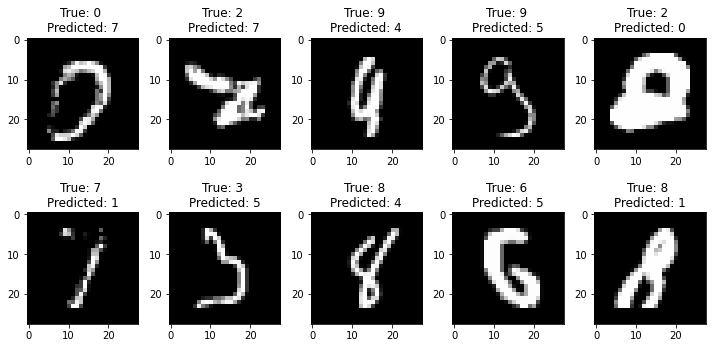

In [13]:
# get miss classified images, their truue labels and predicted labels
miss_images, miss_labels, miss_pred_labels = get_missclassified_records(model_bn, test_loader, device, 10)

# show miss classified images
show_missclassified_images(miss_images, miss_labels, miss_pred_labels, 10)

## LN Training

In [14]:
# model
model_ln = Net(norm_type='LN').to(device)
summary(model_ln, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 28, 28]           2,496
         GroupNorm-2           [-1, 96, 28, 28]             192
            Conv2d-3           [-1, 16, 28, 28]           1,552
         GroupNorm-4           [-1, 16, 28, 28]              32
           Dropout-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 16, 12, 12]           2,320
         GroupNorm-7           [-1, 16, 12, 12]              32
            Conv2d-8            [-1, 8, 12, 12]             136
         GroupNorm-9            [-1, 8, 12, 12]              16
          Dropout-10              [-1, 8, 6, 6]               0
           Conv2d-11             [-1, 16, 4, 4]           1,168
        GroupNorm-12             [-1, 16, 4, 4]              32
           Conv2d-13             [-1, 10, 2, 2]           1,450
AdaptiveAvgPool2d-14             [-1, 1

In [15]:
criterion = nn.CrossEntropyLoss()  # loss
optimizer = optim.SGD(model_ln.parameters(), lr = 0.01, momentum = 0.9)  # optimizer
scheduler = StepLR(optimizer, step_size = 5, gamma = 0.1)  # learning rate scheduler

EPOCHS = 20  # num of epochs
train_ln = Trainer(model_ln, train_loader, criterion, optimizer, device, scheduler)
test_ln = Tester(model_ln, test_loader, criterion, device)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch, " LR: ", train_ln.optimizer.param_groups[0]['lr'])
    train_ln.train()      # train
    test_ln.test()        # test
    scheduler.step()      # scheduler step

EPOCH: 0  LR:  0.01


Loss = 0.01 | Batch = 937 | Accuracy = 91.27: 100%|██████████| 938/938 [00:28<00:00, 33.18it/s]



Test set: Average loss: 0.00102, Accuracy: 98.04

EPOCH: 1  LR:  0.01


Loss = 0.14 | Batch = 937 | Accuracy = 97.16: 100%|██████████| 938/938 [00:28<00:00, 33.25it/s]



Test set: Average loss: 0.00087, Accuracy: 98.22

EPOCH: 2  LR:  0.01


Loss = 0.18 | Batch = 937 | Accuracy = 97.80: 100%|██████████| 938/938 [00:29<00:00, 32.05it/s]



Test set: Average loss: 0.00063, Accuracy: 98.77

EPOCH: 3  LR:  0.01


Loss = 0.13 | Batch = 937 | Accuracy = 98.03: 100%|██████████| 938/938 [00:28<00:00, 32.84it/s]



Test set: Average loss: 0.00055, Accuracy: 98.81

EPOCH: 4  LR:  0.01


Loss = 0.01 | Batch = 937 | Accuracy = 98.20: 100%|██████████| 938/938 [00:28<00:00, 33.28it/s]



Test set: Average loss: 0.00049, Accuracy: 98.99

EPOCH: 5  LR:  0.001


Loss = 0.08 | Batch = 937 | Accuracy = 98.71: 100%|██████████| 938/938 [00:28<00:00, 33.49it/s]



Test set: Average loss: 0.00042, Accuracy: 99.22

EPOCH: 6  LR:  0.001


Loss = 0.01 | Batch = 937 | Accuracy = 98.71: 100%|██████████| 938/938 [00:28<00:00, 32.65it/s]



Test set: Average loss: 0.00042, Accuracy: 99.18

EPOCH: 7  LR:  0.001


Loss = 0.05 | Batch = 937 | Accuracy = 98.80: 100%|██████████| 938/938 [00:28<00:00, 33.25it/s]



Test set: Average loss: 0.00041, Accuracy: 99.24

EPOCH: 8  LR:  0.001


Loss = 0.08 | Batch = 937 | Accuracy = 98.84: 100%|██████████| 938/938 [00:28<00:00, 33.18it/s]



Test set: Average loss: 0.00040, Accuracy: 99.24

EPOCH: 9  LR:  0.001


Loss = 0.08 | Batch = 937 | Accuracy = 98.83: 100%|██████████| 938/938 [00:29<00:00, 31.28it/s]



Test set: Average loss: 0.00040, Accuracy: 99.25

EPOCH: 10  LR:  0.0001


Loss = 0.04 | Batch = 937 | Accuracy = 98.87: 100%|██████████| 938/938 [00:28<00:00, 33.23it/s]



Test set: Average loss: 0.00039, Accuracy: 99.28

EPOCH: 11  LR:  0.0001


Loss = 0.00 | Batch = 937 | Accuracy = 98.91: 100%|██████████| 938/938 [00:27<00:00, 33.77it/s]



Test set: Average loss: 0.00039, Accuracy: 99.28

EPOCH: 12  LR:  0.0001


Loss = 0.06 | Batch = 937 | Accuracy = 98.87: 100%|██████████| 938/938 [00:28<00:00, 33.15it/s]



Test set: Average loss: 0.00039, Accuracy: 99.29

EPOCH: 13  LR:  0.0001


Loss = 0.00 | Batch = 937 | Accuracy = 98.90: 100%|██████████| 938/938 [00:27<00:00, 33.57it/s]



Test set: Average loss: 0.00039, Accuracy: 99.32

EPOCH: 14  LR:  0.0001


Loss = 0.03 | Batch = 937 | Accuracy = 98.81: 100%|██████████| 938/938 [00:28<00:00, 32.75it/s]



Test set: Average loss: 0.00039, Accuracy: 99.33

EPOCH: 15  LR:  1e-05


Loss = 0.02 | Batch = 937 | Accuracy = 98.88: 100%|██████████| 938/938 [00:28<00:00, 32.67it/s]



Test set: Average loss: 0.00039, Accuracy: 99.33

EPOCH: 16  LR:  1e-05


Loss = 0.02 | Batch = 937 | Accuracy = 98.88: 100%|██████████| 938/938 [00:28<00:00, 33.44it/s]



Test set: Average loss: 0.00039, Accuracy: 99.33

EPOCH: 17  LR:  1e-05


Loss = 0.08 | Batch = 937 | Accuracy = 98.94: 100%|██████████| 938/938 [00:28<00:00, 32.73it/s]



Test set: Average loss: 0.00039, Accuracy: 99.33

EPOCH: 18  LR:  1e-05


Loss = 0.11 | Batch = 937 | Accuracy = 98.89: 100%|██████████| 938/938 [00:28<00:00, 33.28it/s]



Test set: Average loss: 0.00039, Accuracy: 99.34

EPOCH: 19  LR:  1e-05


Loss = 0.14 | Batch = 937 | Accuracy = 98.92: 100%|██████████| 938/938 [00:27<00:00, 34.50it/s]



Test set: Average loss: 0.00040, Accuracy: 99.34



#### Model Performance (LN)

In [16]:
# model performance
evaluate(model_ln, train_loader, criterion, device, split = 'Train')
evaluate(model_ln, test_loader, criterion, device, split = 'Test')


Train set: Average loss: 0.00045, Accuracy: 99.08


Test set: Average loss: 0.00039, Accuracy: 99.34



#### Misclassified Images of LN

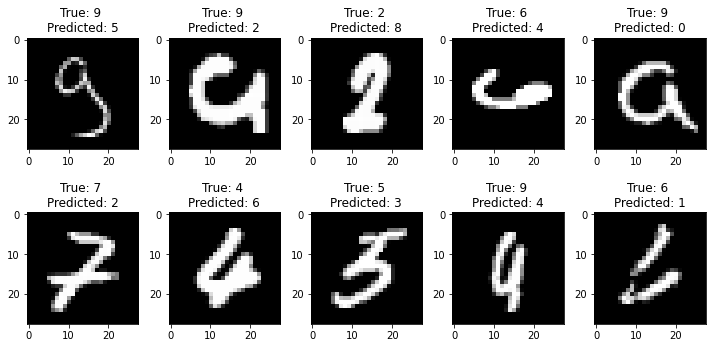

In [17]:
# get miss classified images, their truue labels and predicted labels
miss_images, miss_labels, miss_pred_labels = get_missclassified_records(model_ln, test_loader, device, 10)

# show miss classified images
show_missclassified_images(miss_images, miss_labels, miss_pred_labels, 10)

## GN Training

In [18]:
# model
model_gn = Net(norm_type='GN').to(device)
summary(model_gn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 28, 28]           2,496
         GroupNorm-2           [-1, 96, 28, 28]             192
            Conv2d-3           [-1, 16, 28, 28]           1,552
         GroupNorm-4           [-1, 16, 28, 28]              32
           Dropout-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 16, 12, 12]           2,320
         GroupNorm-7           [-1, 16, 12, 12]              32
            Conv2d-8            [-1, 8, 12, 12]             136
         GroupNorm-9            [-1, 8, 12, 12]              16
          Dropout-10              [-1, 8, 6, 6]               0
           Conv2d-11             [-1, 16, 4, 4]           1,168
        GroupNorm-12             [-1, 16, 4, 4]              32
           Conv2d-13             [-1, 10, 2, 2]           1,450
AdaptiveAvgPool2d-14             [-1, 1

In [19]:
criterion = nn.CrossEntropyLoss()  # loss
optimizer = optim.SGD(model_gn.parameters(), lr = 0.01, momentum = 0.9)  # optimizer
scheduler = StepLR(optimizer, step_size = 5, gamma = 0.1)  # learning rate scheduler

EPOCHS = 20  # num of epochs
train_gn = Trainer(model_gn, train_loader, criterion, optimizer, device, scheduler)
test_gn = Tester(model_gn, test_loader, criterion, device)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch, " LR: ", train_gn.optimizer.param_groups[0]['lr'])
    train_gn.train()      # train
    test_gn.test()        # test
    scheduler.step()      # scheduler step

EPOCH: 0  LR:  0.01


Loss = 0.06 | Batch = 937 | Accuracy = 92.08: 100%|██████████| 938/938 [00:28<00:00, 33.27it/s]



Test set: Average loss: 0.00103, Accuracy: 97.97

EPOCH: 1  LR:  0.01


Loss = 0.04 | Batch = 937 | Accuracy = 97.21: 100%|██████████| 938/938 [00:28<00:00, 32.98it/s]



Test set: Average loss: 0.00109, Accuracy: 97.67

EPOCH: 2  LR:  0.01


Loss = 0.22 | Batch = 937 | Accuracy = 97.67: 100%|██████████| 938/938 [00:27<00:00, 33.54it/s]



Test set: Average loss: 0.00071, Accuracy: 98.64

EPOCH: 3  LR:  0.01


Loss = 0.05 | Batch = 937 | Accuracy = 97.92: 100%|██████████| 938/938 [00:29<00:00, 32.05it/s]



Test set: Average loss: 0.00064, Accuracy: 98.73

EPOCH: 4  LR:  0.01


Loss = 0.04 | Batch = 937 | Accuracy = 98.19: 100%|██████████| 938/938 [00:28<00:00, 33.27it/s]



Test set: Average loss: 0.00051, Accuracy: 98.90

EPOCH: 5  LR:  0.001


Loss = 0.02 | Batch = 937 | Accuracy = 98.61: 100%|██████████| 938/938 [00:27<00:00, 33.50it/s]



Test set: Average loss: 0.00043, Accuracy: 99.10

EPOCH: 6  LR:  0.001


Loss = 0.10 | Batch = 937 | Accuracy = 98.69: 100%|██████████| 938/938 [00:28<00:00, 33.36it/s]



Test set: Average loss: 0.00041, Accuracy: 99.13

EPOCH: 7  LR:  0.001


Loss = 0.00 | Batch = 937 | Accuracy = 98.69: 100%|██████████| 938/938 [00:28<00:00, 33.35it/s]



Test set: Average loss: 0.00041, Accuracy: 99.12

EPOCH: 8  LR:  0.001


Loss = 0.01 | Batch = 937 | Accuracy = 98.72: 100%|██████████| 938/938 [00:27<00:00, 34.07it/s]



Test set: Average loss: 0.00041, Accuracy: 99.16

EPOCH: 9  LR:  0.001


Loss = 0.16 | Batch = 937 | Accuracy = 98.84: 100%|██████████| 938/938 [00:27<00:00, 34.33it/s]



Test set: Average loss: 0.00040, Accuracy: 99.15

EPOCH: 10  LR:  0.0001


Loss = 0.00 | Batch = 937 | Accuracy = 98.81: 100%|██████████| 938/938 [00:28<00:00, 33.18it/s]



Test set: Average loss: 0.00039, Accuracy: 99.17

EPOCH: 11  LR:  0.0001


Loss = 0.00 | Batch = 937 | Accuracy = 98.81: 100%|██████████| 938/938 [00:27<00:00, 34.08it/s]



Test set: Average loss: 0.00039, Accuracy: 99.16

EPOCH: 12  LR:  0.0001


Loss = 0.00 | Batch = 937 | Accuracy = 98.83: 100%|██████████| 938/938 [00:27<00:00, 34.11it/s]



Test set: Average loss: 0.00039, Accuracy: 99.16

EPOCH: 13  LR:  0.0001


Loss = 0.00 | Batch = 937 | Accuracy = 98.87: 100%|██████████| 938/938 [00:27<00:00, 34.01it/s]



Test set: Average loss: 0.00039, Accuracy: 99.16

EPOCH: 14  LR:  0.0001


Loss = 0.05 | Batch = 937 | Accuracy = 98.85: 100%|██████████| 938/938 [00:28<00:00, 33.05it/s]



Test set: Average loss: 0.00039, Accuracy: 99.19

EPOCH: 15  LR:  1e-05


Loss = 0.03 | Batch = 937 | Accuracy = 98.81: 100%|██████████| 938/938 [00:27<00:00, 34.14it/s]



Test set: Average loss: 0.00039, Accuracy: 99.18

EPOCH: 16  LR:  1e-05


Loss = 0.01 | Batch = 937 | Accuracy = 98.89: 100%|██████████| 938/938 [00:27<00:00, 33.92it/s]



Test set: Average loss: 0.00039, Accuracy: 99.20

EPOCH: 17  LR:  1e-05


Loss = 0.01 | Batch = 937 | Accuracy = 98.84: 100%|██████████| 938/938 [00:27<00:00, 33.50it/s]



Test set: Average loss: 0.00039, Accuracy: 99.19

EPOCH: 18  LR:  1e-05


Loss = 0.00 | Batch = 937 | Accuracy = 98.77: 100%|██████████| 938/938 [00:27<00:00, 33.63it/s]



Test set: Average loss: 0.00039, Accuracy: 99.18

EPOCH: 19  LR:  1e-05


Loss = 0.00 | Batch = 937 | Accuracy = 98.87: 100%|██████████| 938/938 [00:27<00:00, 34.06it/s]



Test set: Average loss: 0.00039, Accuracy: 99.17



#### Model Performance (GN)

In [20]:
# model performance
evaluate(model_gn, train_loader, criterion, device, split = 'Train')
evaluate(model_gn, test_loader, criterion, device, split = 'Test')


Train set: Average loss: 0.00046, Accuracy: 99.07


Test set: Average loss: 0.00039, Accuracy: 99.17



#### Misclassified Images of GN

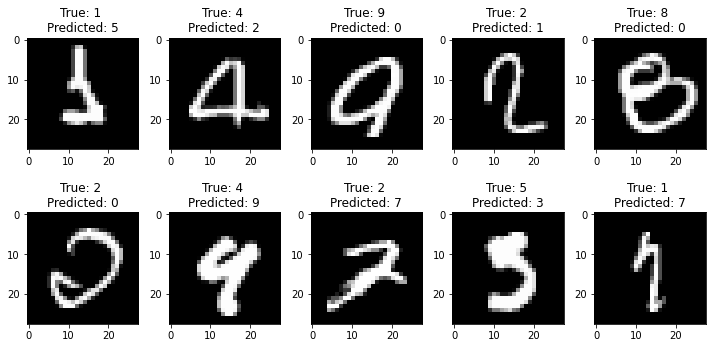

In [21]:
# get miss classified images, their truue labels and predicted labels
miss_images, miss_labels, miss_pred_labels = get_missclassified_records(model_gn, test_loader, device, 10)

# show miss classified images
show_missclassified_images(miss_images, miss_labels, miss_pred_labels, 10)

# Performance Plots

#### Validation Loss

Text(0, 0.5, 'Val Loss')

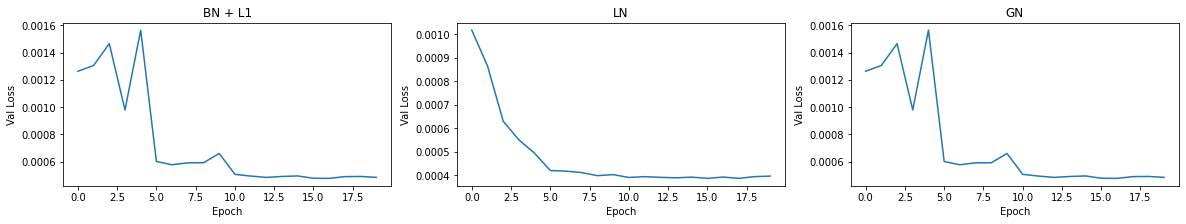

In [24]:
# loss plots
fig, axs = plt.subplots(1, 3, figsize = (20, 3))
axs[0].plot(range(EPOCHS), test_bn.test_losses)
axs[0].set_title("BN + L1")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Val Loss')
axs[1].plot(range(EPOCHS), test_ln.test_losses)
axs[1].set_title("LN")
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Val Loss')
axs[2].plot(range(EPOCHS), test_bn.test_losses)
axs[2].set_title("GN")
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Val Loss')

#### Validation Accuracy

Text(0, 0.5, 'Val Acc')

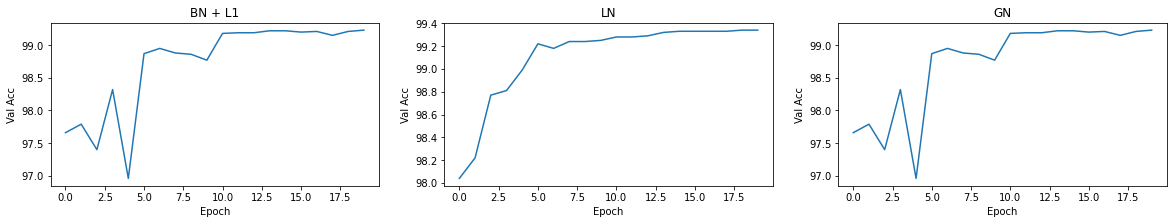

In [25]:
# accuracy plots
fig, axs = plt.subplots(1, 3, figsize = (20, 3))
axs[0].plot(range(EPOCHS), test_bn.test_accs)
axs[0].set_title("BN + L1")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Val Acc')
axs[1].plot(range(EPOCHS), test_ln.test_accs)
axs[1].set_title("LN")
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Val Acc')
axs[2].plot(range(EPOCHS), test_bn.test_accs)
axs[2].set_title("GN")
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Val Acc')